# Используемые библиотеки

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns
%matplotlib inline
import numpy as np 
import pandas as pd 

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error as mse, r2_score as r2

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
def nan_analize(X):
    nan_df = (X.isna().sum() / X.shape[0]).reset_index()
    nan_df.columns=['feature', 'nan_percent']

    plt.figure(figsize=(16,4))
    sns.barplot(nan_df['feature'], nan_df['nan_percent'])
    plt.title('Percent Missing')
    plt.ylabel('Missing', fontsize=12)
    plt.xlabel('Features', fontsize=12)
    plt.xticks(rotation=90)
    plt.show()

In [4]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 5)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

In [5]:
def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    # plt.savefig('fe.jpg')
    plt.show()

# Загрузка данных

In [28]:
df = pd.read_csv('data\data_set_to_train.csv')

X = df.drop('median_house_value', axis=1)
y = df[['Id ', 'median_house_value']]
X.set_index('Id ', inplace=True)
y.set_index('Id ', inplace=True)

X_final = pd.read_csv('data\data_set_to_test_X.csv')
X_final.set_index('Id ', inplace=True)
final_index_list = X_final.index

print('Строк в трейне:' ,  X.shape[0])
print('Строк в тесте', X_final.shape[0])

Строк в трейне: 13828
Строк в тесте 6812


In [29]:
df.columns

Index(['Id ', 'longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity', 'median_house_value'],
      dtype='object')

In [30]:
X = reduce_mem_usage(X)

Memory usage of dataframe is 1.05 MB
Memory usage after optimization is: 0.54 MB
Decreased by 48.7%


In [31]:
X_final = reduce_mem_usage(X_final)

Memory usage of dataframe is 0.52 MB
Memory usage after optimization is: 0.27 MB
Decreased by 48.7%


# Смотрим данные (EDA)

**Описание датасета**

Статистические данные о ряде домов в Калифорнии, основанные на переписи 1990 года.

* **longitude** - долгота
* **latitude** - широта
* **housing_median_age** - средний возраст дома
* **total_rooms** - общее количество комнат
* **total_bedrooms** - общее количество спален
* **population** - количество проживающих
* **households** - домохозяйства
* **ocean_proximity** - близость океана
* **median_income** - средний доход
* **median_house_value** - средняя стоимость дома

In [188]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
Id,,,,,,,,,
5088,-118.279999,33.980000,19.0,883.0,313.0,726.0,277.0,0.9809,<1H OCEAN
17096,-122.230003,37.459999,33.0,2643.0,464.0,1015.0,427.0,4.2232,NEAR OCEAN
5617,-118.260002,33.790001,42.0,1162.0,264.0,1044.0,241.0,3.5488,<1H OCEAN
20060,-119.260002,35.869999,24.0,1590.0,390.0,1686.0,372.0,1.6469,INLAND
895,-121.959999,37.540001,14.0,5106.0,1207.0,2738.0,1108.0,3.9909,<1H OCEAN


In [189]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13828 entries, 5088 to 15795
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           13828 non-null  float32 
 1   latitude            13828 non-null  float32 
 2   housing_median_age  13349 non-null  float32 
 3   total_rooms         13828 non-null  float32 
 4   total_bedrooms      13828 non-null  float32 
 5   population          13429 non-null  float32 
 6   households          13828 non-null  float32 
 7   median_income       13828 non-null  float32 
 8   ocean_proximity     13828 non-null  category
dtypes: category(1), float32(8)
memory usage: 553.9 KB


In [102]:
X.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

In [103]:
X.shape

(13828, 9)

In [104]:
X[['longitude', 'latitude']].head(5)

,longitude,latitude
Id,,
5088,-118.279999,33.980000
17096,-122.230003,37.459999
5617,-118.260002,33.790001
20060,-119.260002,35.869999
895,-121.959999,37.540001


## Переменные

In [105]:
X.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,13828.000000,13828.000000,13349.000000,13828.000000,13828.000000,13429.000000,13828.000000,13828.000000
mean,-119.489861,34.763271,28.569706,2647.572998,540.267151,1430.852661,501.675446,3.876735
std,4.857742,115.936920,12.583060,2171.663818,421.248840,1148.826538,383.638641,1.903102
min,-124.349998,-13534.030273,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900
25%,-121.809998,33.939999,18.000000,1455.000000,297.000000,791.000000,280.000000,2.568575
50%,-118.510002,34.270000,29.000000,2139.000000,437.000000,1168.000000,412.000000,3.538750
75%,-118.010002,37.720001,37.000000,3166.000000,648.000000,1732.000000,607.000000,4.756600
max,121.290001,1327.130005,52.000000,32627.000000,6445.000000,35682.000000,6082.000000,15.000100


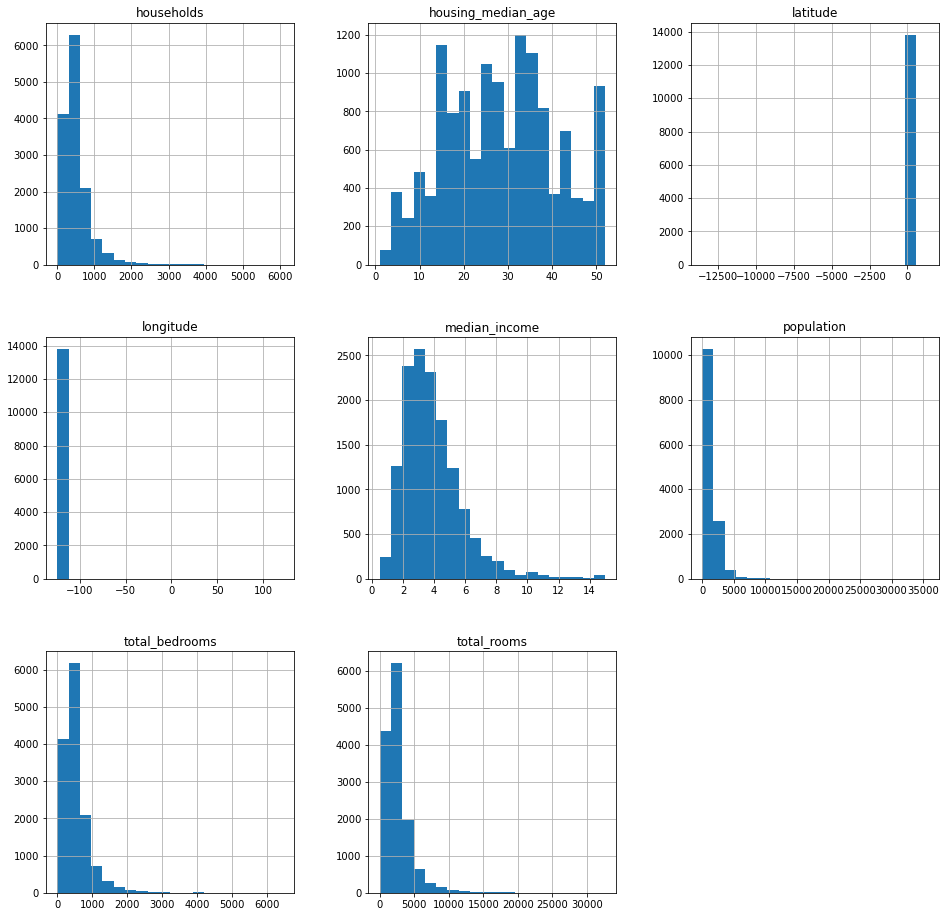

In [16]:
X.hist(figsize=(16,16), bins=20);

                    longitude  latitude  housing_median_age  total_rooms  \
longitude            1.000000 -0.009715           -0.039775     0.035243   
latitude            -0.009715  1.000000           -0.011278     0.005695   
housing_median_age  -0.039775 -0.011278            1.000000    -0.361614   
total_rooms          0.035243  0.005695           -0.361614     1.000000   
total_bedrooms       0.043869  0.006314           -0.321267     0.929825   
population           0.060158  0.006036           -0.290628     0.855977   
households           0.039350  0.006354           -0.302934     0.920828   
median_income       -0.003205 -0.018312           -0.115285     0.197146   

                    total_bedrooms  population  households  median_income  
longitude                 0.043869    0.060158    0.039350      -0.003205  
latitude                  0.006314    0.006036    0.006354      -0.018312  
housing_median_age       -0.321267   -0.290628   -0.302934      -0.115285  
total_rooms

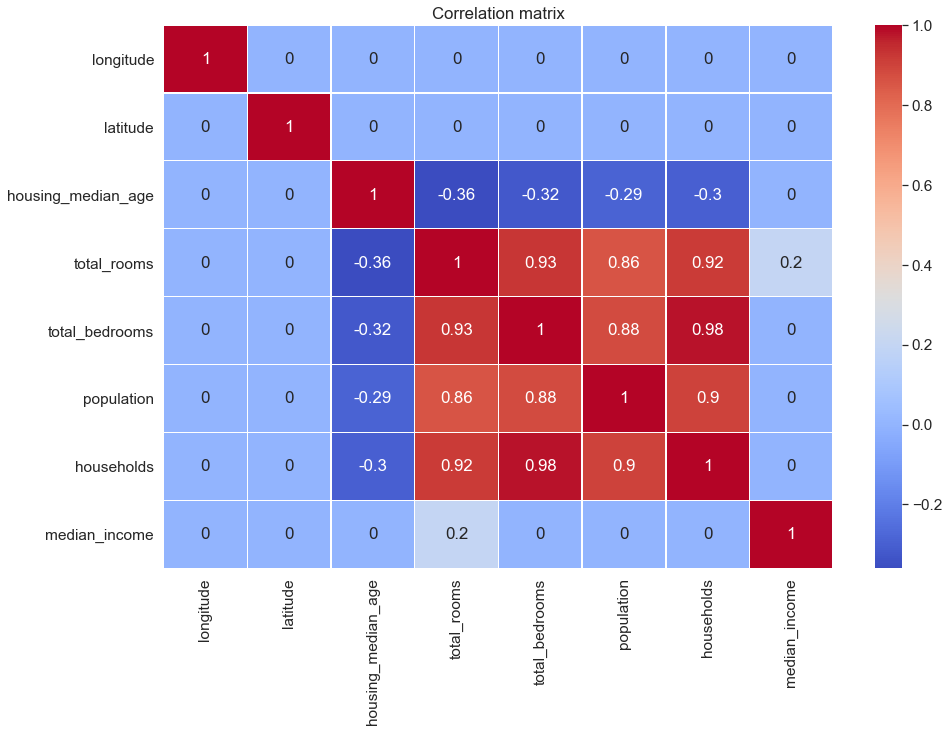

In [17]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = X.corr()
print(X.corr())
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.2] = 0  # Проверьте, что будет если убрать маленькие корреляции

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

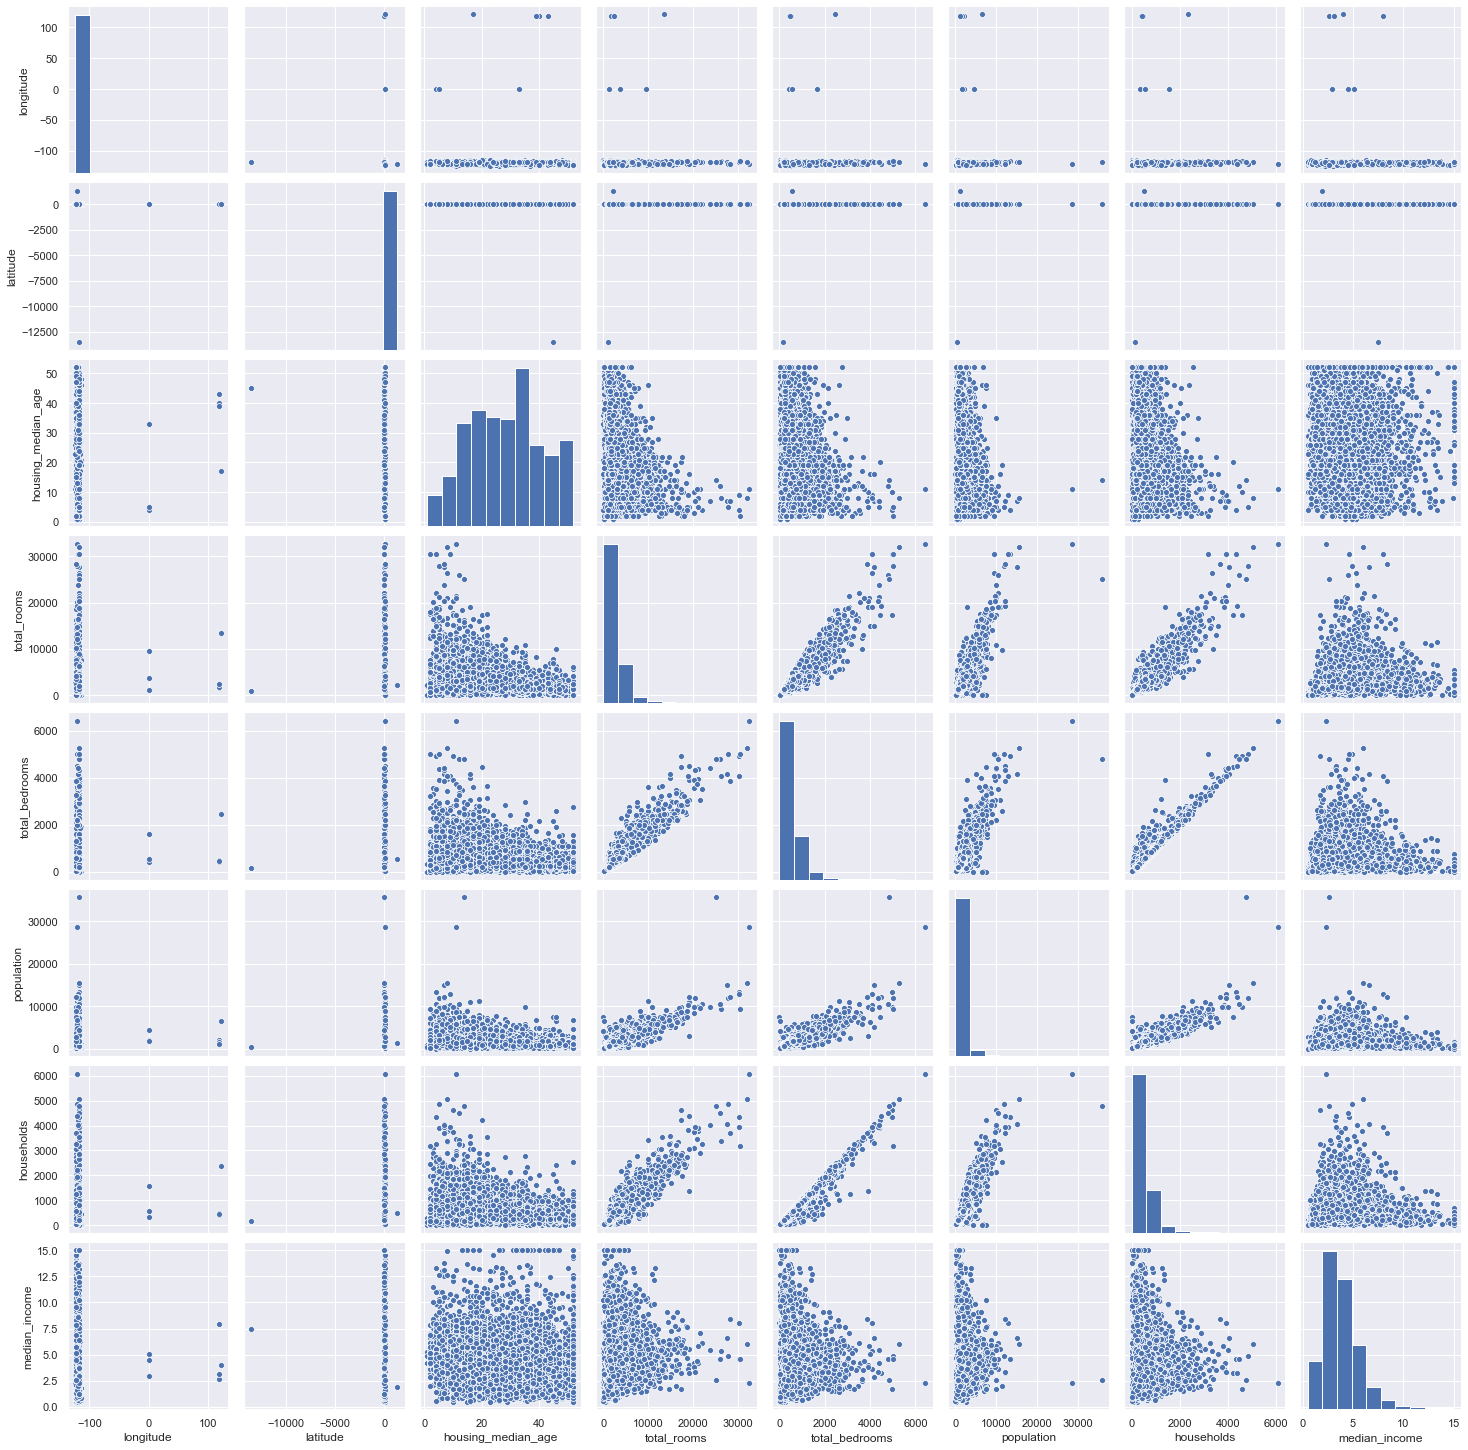

In [18]:
sns.set()
sns.pairplot(X, height = 2.5)
plt.show()

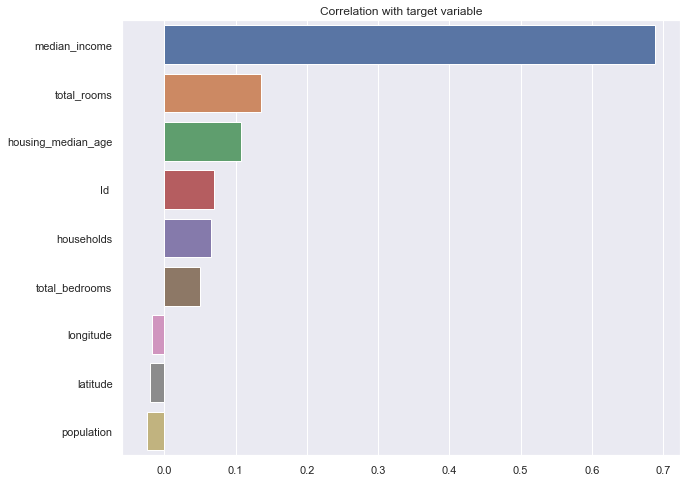

In [19]:
corr_with_target = df.corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

In [20]:
X['ocean_proximity'].value_counts()

<1H OCEAN     6144
INLAND        4414
NEAR OCEAN    1702
NEAR BAY      1552
-               13
ISLAND           3
Name: ocean_proximity, dtype: int64

# Исправляем и дополняем

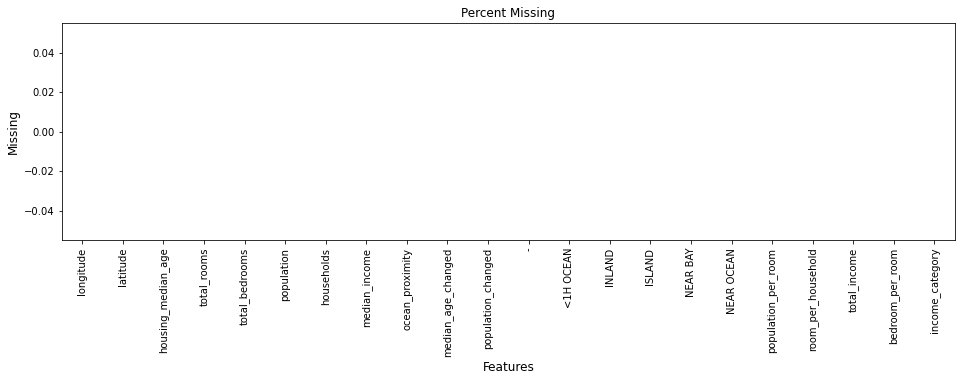

In [51]:
nan_analize(X)

In [33]:
X['median_age_changed'] = 0
X_final['median_age_changed'] = 0

X.loc[X.isna()['housing_median_age'] == True, 'median_age_changed'] = 1
X_final.loc[X_final.isna()['housing_median_age'] == True, 'median_age_changed'] = 1

median = X['housing_median_age'].median()
X['housing_median_age'] = X['housing_median_age'].fillna(median)
median = X_final['housing_median_age'].median()
X_final['housing_median_age'] = X_final['housing_median_age'].fillna(median)

In [34]:
X['population_changed'] = 0
X_final['population_changed'] = 0

X.loc[X.isna()['population'] == True, 'population_changed'] = 1
X_final.loc[X_final.isna()['population'] == True, 'population_changed'] = 1

median = X['population'].median()
X['population'] = X['population'].fillna(median)
median = X_final['population'].median()
X_final['population'] = X_final['population'].fillna(median)

In [35]:
median = X['total_bedrooms'].median()
X['total_bedrooms'] = X['total_bedrooms'].fillna(median)
median = X_final['total_bedrooms'].median()
X_final['total_bedrooms'] = X_final['total_bedrooms'].fillna(median)

In [36]:
X.loc[X['longitude'] > 0, 'longitude'] = X.loc[X['longitude'] > 0, 'longitude'] * -1
X_final.loc[X_final['longitude'] > 0, 'longitude'] = X_final.loc[X_final['longitude'] > 0, 'longitude'] * -1

In [37]:
X.loc[8283, 'latitude'] = 33.700000
X.loc[12772, 'latitude'] = 40.600000

X.loc[19423, 'longitude'] = -121.600000
X.loc[17085, 'longitude'] = -121.900000
X.loc[17359, 'longitude'] = -118.500000

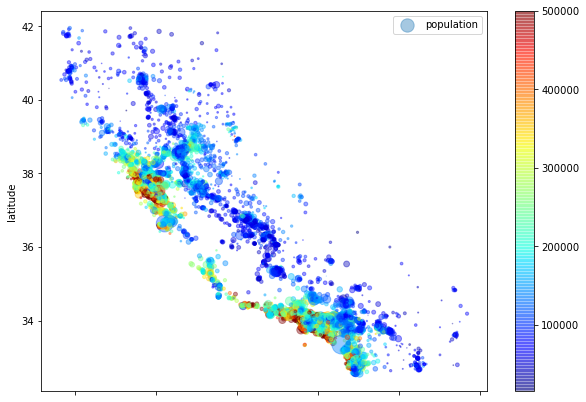

In [38]:
X.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, 
    s=X['population']/100, label='population', figsize=(10,7), 
    c=y['median_house_value'], cmap=plt.get_cmap('jet'), colorbar=True)

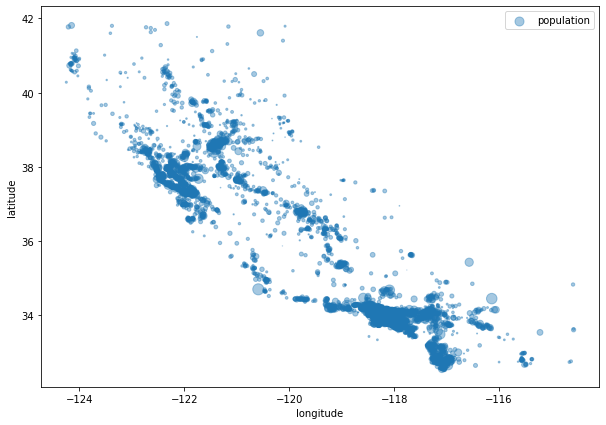

In [39]:
X_final.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, 
    s=X_final['population']/100, label='population', figsize=(10,7))

In [40]:
X = pd.concat([X, pd.get_dummies(X['ocean_proximity'])], axis=1)
X_final = pd.concat([X_final, pd.get_dummies(X_final['ocean_proximity'])], axis=1)

In [41]:
X['population_per_room'] = X['population'] / X['total_rooms']
X_final['population_per_room'] = X_final['population'] / X_final['total_rooms']

In [42]:
X['room_per_household'] = X['total_rooms'] / X['households']
X_final['room_per_household'] = X_final['total_rooms'] / X_final['households']

In [43]:
X['total_income'] = X['households'] * X['median_income']
X_final['total_income'] = X_final['households'] * X_final['median_income']

In [44]:
X.loc[X['total_bedrooms'] >= X['total_rooms'] ].head(20)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_age_changed,population_changed,-,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,population_per_room,room_per_household,total_income
Id,,,,,,,,,,,,,,,,,,,,
3126,-117.790001,35.209999,4.0,2.0,2.0,6.0,2.0,2.375,INLAND,0,0,0,0,1,0,0,0,3.000000,1.000000,4.750
19435,-121.040001,37.669998,16.0,19.0,19.0,166.0,9.0,0.536,INLAND,0,0,0,0,1,0,0,0,8.736842,2.111111,4.824


In [45]:
X['bedroom_per_room'] = X['total_bedrooms'] / X['total_rooms']
X_final['bedroom_per_room'] = X_final['total_bedrooms'] / X_final['total_rooms']

In [46]:
X['income_category'] = np.ceil(X['median_income'])
X_final['income_category'] = np.ceil(X_final['median_income'])

In [49]:
for i in range(1, 17):
    print(i, len(X.loc[X['income_category'] == i]), len(X_final.loc[X_final['income_category'] == i]))

1 1648 809
2 3290 1656
3 3439 1711
4 2433 1165
5 1436 691
6 1120 552
7 462 228
8 0 0
9 0 0
10 0 0
11 0 0
12 0 0
13 0 0
14 0 0
15 0 0
16 0 0


In [48]:
X.loc[X['income_category'] == 2, 'income_category'] = 1
X.loc[X['income_category'] == 3, 'income_category'] = 2
X.loc[X['income_category'] == 4, 'income_category'] = 3
X.loc[X['income_category'] == 5, 'income_category'] = 4
X.loc[X['income_category'] == 6, 'income_category'] = 5
X.loc[X['income_category'] == 7, 'income_category'] = 6
X.loc[X['income_category'] == 8, 'income_category'] = 6
X.loc[X['income_category'] > 8, 'income_category'] = 7

X_final.loc[X_final['income_category'] == 2, 'income_category'] = 1
X_final.loc[X_final['income_category'] == 3, 'income_category'] = 2
X_final.loc[X_final['income_category'] == 4, 'income_category'] = 3
X_final.loc[X_final['income_category'] == 5, 'income_category'] = 4
X_final.loc[X_final['income_category'] == 6, 'income_category'] = 5
X_final.loc[X_final['income_category'] == 7, 'income_category'] = 6
X_final.loc[X_final['income_category'] == 8, 'income_category'] = 6
X_final.loc[X_final['income_category'] > 8, 'income_category'] = 7

                     longitude  latitude  housing_median_age  total_rooms  \
longitude             1.000000 -0.923823           -0.097694     0.036253   
latitude             -0.923823  1.000000            0.001168    -0.027428   
housing_median_age   -0.097694  0.001168            1.000000    -0.353582   
total_rooms           0.036253 -0.027428           -0.353582     1.000000   
total_bedrooms        0.061102 -0.058482           -0.314508     0.929825   
population            0.088904 -0.097622           -0.281327     0.842978   
households            0.046370 -0.061299           -0.296360     0.920828   
median_income        -0.019522 -0.075066           -0.112840     0.197146   
median_age_changed   -0.005593  0.006221            0.006365     0.017660   
population_changed    0.001003 -0.002704            0.010614     0.001998   
coordinates_changed  -0.006877  0.010842           -0.008284     0.007956   
-                    -0.002466  0.000909           -0.007558    -0.006780   

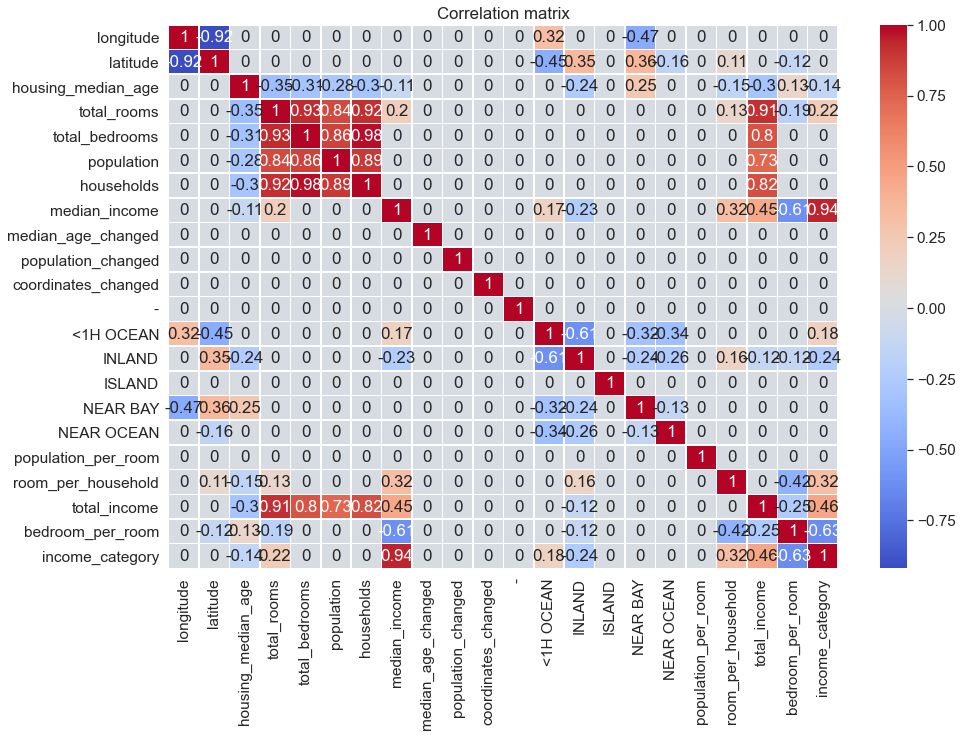

In [107]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = X.corr()
print(X.corr())
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) <= 0.1] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

In [52]:
X.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_age_changed,population_changed,...,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,population_per_room,room_per_household,total_income,bedroom_per_room,income_category
count,13828.000000,13828.000000,13828.000000,13828.000000,13828.000000,13828.000000,13828.000000,13828.000000,13828.000000,13828.000000,...,13828.000000,13828.000000,13828.000000,13828.000000,13828.000000,13828.000000,13828.000000,13828.000000,13828.000000,13828.000000
mean,-119.584946,35.651432,28.584610,2647.572998,540.267151,1423.267578,501.675446,3.876735,0.034640,0.028854,...,0.444316,0.319207,0.000217,0.112236,0.123084,0.637027,5.436546,1952.576416,0.213001,3.283989
std,2.005138,2.134328,12.363278,2171.663818,421.248840,1132.986938,383.638641,1.903102,0.182873,0.167404,...,0.496908,0.466186,0.014728,0.315668,0.328545,3.532465,2.449446,1906.061523,0.058328,1.577628
min,-124.349998,32.549999,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.019218,0.888889,1.608000,0.100000,1.000000
25%,-121.809998,33.939999,18.000000,1455.000000,297.000000,801.000000,280.000000,2.568575,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.433649,4.459802,870.871826,0.175255,2.000000
50%,-118.510002,34.270000,29.000000,2139.000000,437.000000,1168.000000,412.000000,3.538750,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.516548,5.232422,1463.781006,0.202996,3.000000
75%,-118.010002,37.720001,37.000000,3166.000000,648.000000,1710.000000,607.000000,4.756600,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.658146,6.058565,2403.553894,0.239353,4.000000
max,-114.309998,41.950001,52.000000,32627.000000,6445.000000,35682.000000,6082.000000,15.000100,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,392.631592,141.909088,31501.853516,1.000000,7.000000


In [53]:
X_final.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_age_changed,population_changed,...,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,population_per_room,room_per_household,total_income,bedroom_per_room,income_category
count,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000,...,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000
mean,-119.538300,35.592514,28.830446,2611.800293,529.727661,1406.821045,495.204193,3.858350,0.035672,0.029360,...,0.437904,0.312390,0.000294,0.108045,0.139900,0.604593,5.413654,1923.620850,0.215302,3.270258
std,2.000073,2.139396,12.337366,2201.645996,415.576874,1091.458130,379.648621,1.893224,0.185486,0.168826,...,0.496165,0.463502,0.017133,0.310460,0.346909,0.571533,2.523734,1893.785400,0.076911,1.577052
min,-124.250000,32.540001,1.000000,6.000000,2.000000,8.000000,2.000000,0.499900,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.018109,0.846154,2.999400,0.036724,1.000000
25%,-121.760002,33.919998,19.000000,1434.000000,298.000000,786.750000,279.000000,2.550775,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.435523,4.409941,850.110611,0.175096,2.000000
50%,-118.480003,34.230000,29.000000,2106.000000,430.000000,1157.000000,406.000000,3.527800,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.515201,5.224030,1453.958069,0.203509,3.000000
75%,-117.989998,37.709999,37.000000,3109.250000,631.000000,1689.000000,598.000000,4.733225,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.660210,6.040538,2352.117737,0.241587,4.000000
max,-114.580002,41.860001,52.000000,39320.000000,6210.000000,16305.000000,5358.000000,15.000100,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,32.138889,132.533340,38890.000000,2.792208,7.000000


In [109]:
X.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity', 'median_age_changed', 'population_changed',
       'coordinates_changed', '-', '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY',
       'NEAR OCEAN', 'population_per_room', 'room_per_household',
       'total_income', 'bedroom_per_room', 'income_category'],
      dtype='object')

# Проверяем модель

In [ ]:
#0.82598  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', '-', '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']
#0.83272  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', '-', '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN', 'population_per_room',
#0.83306  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', '-', '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN', 'population_per_room', 'median_age_changed']
#0.83321  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', '-', '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN', 'population_per_room', 'median_age_changed', 'population_changed']
#0.83374  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', '-', '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN', 'population_per_room', 'median_age_changed', 'population_changed', 'income_category']
#0.83500  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'population', 'households', 'median_income', '-', '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN', 'population_per_room', 'median_age_changed', 'population_changed', 'income_category', 'bedroom_per_room']
#0.83558  max_depth=16, n_estimators=325
#0.83582  max_depth=17, n_estimators=300, num_leaves=32


In [54]:
remain_features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'population', 'households', 'median_income', '-', '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN', 'population_per_room', 'median_age_changed', 'population_changed', 'income_category', 'bedroom_per_room']

X1 = X[remain_features]
X1_final = X_final[remain_features]

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.3, random_state=42)

In [191]:
maximum = 0
maxi = 0
maxk = 0
maxm = 0
summary = 11 * 31 * 11
count = 0
for i in range(10, 21, 1):
    for k in range(200, 351, 5):
        for m in range(25, 36, 1):
            model = LGBMRegressor(max_depth=i,
                     n_estimators=k, num_leaves=m,
                     random_state=42)
            model.fit(X_train, y_train)

            y_pred_test = model.predict(X_test)
            for j in range(len(y_pred_test)):
                if y_pred_test[j] > 500000:
                    y_pred_test[j] = 500001

            score = r2(y_test['median_house_value'], y_pred_test)
            if score > maximum:
                maximum = score
                maxi = i
                maxk = k
                maxm = m
            count += 1
            print(f"i: {i}   k: {k}   m: {m}   score: {round(score, 4)}    {round(count * 100 / summary, 2)} %")

print(f"(max_depth={maxi}, n_estimators={maxk}, num_leaves={maxm}, random_state=42)")
print(f"score: {maximum}")

i: 10   k: 200   m: 25   score: 0.8311    0.03 %
i: 10   k: 200   m: 26   score: 0.8316    0.05 %
i: 10   k: 200   m: 27   score: 0.8293    0.08 %
i: 10   k: 200   m: 28   score: 0.8304    0.11 %
i: 10   k: 200   m: 29   score: 0.8328    0.13 %
i: 10   k: 200   m: 30   score: 0.8286    0.16 %
i: 10   k: 200   m: 31   score: 0.8318    0.19 %
i: 10   k: 200   m: 32   score: 0.8299    0.21 %
i: 10   k: 200   m: 33   score: 0.8323    0.24 %
i: 10   k: 200   m: 34   score: 0.8305    0.27 %
i: 10   k: 200   m: 35   score: 0.8309    0.29 %
i: 10   k: 205   m: 25   score: 0.8311    0.32 %
i: 10   k: 205   m: 26   score: 0.8318    0.35 %
i: 10   k: 205   m: 27   score: 0.8297    0.37 %
i: 10   k: 205   m: 28   score: 0.8301    0.4 %
i: 10   k: 205   m: 29   score: 0.8332    0.43 %
i: 10   k: 205   m: 30   score: 0.8286    0.45 %
i: 10   k: 205   m: 31   score: 0.8317    0.48 %
i: 10   k: 205   m: 32   score: 0.8302    0.51 %
i: 10   k: 205   m: 33   score: 0.8325    0.53 %
i: 10   k: 205   m: 3

i: 10   k: 275   m: 28   score: 0.832    4.51 %
i: 10   k: 275   m: 29   score: 0.8347    4.53 %
i: 10   k: 275   m: 30   score: 0.8315    4.56 %
i: 10   k: 275   m: 31   score: 0.833    4.59 %
i: 10   k: 275   m: 32   score: 0.8327    4.61 %
i: 10   k: 275   m: 33   score: 0.8339    4.64 %
i: 10   k: 275   m: 34   score: 0.8322    4.67 %
i: 10   k: 275   m: 35   score: 0.8321    4.69 %
i: 10   k: 280   m: 25   score: 0.8327    4.72 %
i: 10   k: 280   m: 26   score: 0.8339    4.75 %
i: 10   k: 280   m: 27   score: 0.8323    4.77 %
i: 10   k: 280   m: 28   score: 0.8323    4.8 %
i: 10   k: 280   m: 29   score: 0.8348    4.83 %
i: 10   k: 280   m: 30   score: 0.8314    4.85 %
i: 10   k: 280   m: 31   score: 0.8331    4.88 %
i: 10   k: 280   m: 32   score: 0.8326    4.91 %
i: 10   k: 280   m: 33   score: 0.8338    4.93 %
i: 10   k: 280   m: 34   score: 0.8324    4.96 %
i: 10   k: 280   m: 35   score: 0.832    4.99 %
i: 10   k: 285   m: 25   score: 0.8327    5.01 %
i: 10   k: 285   m: 26  

i: 10   k: 350   m: 31   score: 0.834    8.98 %
i: 10   k: 350   m: 32   score: 0.8328    9.01 %
i: 10   k: 350   m: 33   score: 0.8344    9.04 %
i: 10   k: 350   m: 34   score: 0.8326    9.06 %
i: 10   k: 350   m: 35   score: 0.8323    9.09 %
i: 11   k: 200   m: 25   score: 0.8312    9.12 %
i: 11   k: 200   m: 26   score: 0.8292    9.14 %
i: 11   k: 200   m: 27   score: 0.8322    9.17 %
i: 11   k: 200   m: 28   score: 0.8281    9.2 %
i: 11   k: 200   m: 29   score: 0.831    9.22 %
i: 11   k: 200   m: 30   score: 0.831    9.25 %
i: 11   k: 200   m: 31   score: 0.8332    9.28 %
i: 11   k: 200   m: 32   score: 0.8317    9.3 %
i: 11   k: 200   m: 33   score: 0.8302    9.33 %
i: 11   k: 200   m: 34   score: 0.8315    9.36 %
i: 11   k: 200   m: 35   score: 0.8307    9.38 %
i: 11   k: 205   m: 25   score: 0.8314    9.41 %
i: 11   k: 205   m: 26   score: 0.83    9.44 %
i: 11   k: 205   m: 27   score: 0.8323    9.46 %
i: 11   k: 205   m: 28   score: 0.8284    9.49 %
i: 11   k: 205   m: 29   sc

i: 11   k: 270   m: 32   score: 0.8329    13.41 %
i: 11   k: 270   m: 33   score: 0.8321    13.44 %
i: 11   k: 270   m: 34   score: 0.8326    13.46 %
i: 11   k: 270   m: 35   score: 0.8319    13.49 %
i: 11   k: 275   m: 25   score: 0.8323    13.52 %
i: 11   k: 275   m: 26   score: 0.8324    13.54 %
i: 11   k: 275   m: 27   score: 0.8338    13.57 %
i: 11   k: 275   m: 28   score: 0.8294    13.6 %
i: 11   k: 275   m: 29   score: 0.8319    13.62 %
i: 11   k: 275   m: 30   score: 0.8314    13.65 %
i: 11   k: 275   m: 31   score: 0.8344    13.68 %
i: 11   k: 275   m: 32   score: 0.8327    13.7 %
i: 11   k: 275   m: 33   score: 0.8322    13.73 %
i: 11   k: 275   m: 34   score: 0.8329    13.76 %
i: 11   k: 275   m: 35   score: 0.8318    13.78 %
i: 11   k: 280   m: 25   score: 0.8324    13.81 %
i: 11   k: 280   m: 26   score: 0.8325    13.84 %
i: 11   k: 280   m: 27   score: 0.8338    13.86 %
i: 11   k: 280   m: 28   score: 0.8294    13.89 %
i: 11   k: 280   m: 29   score: 0.8322    13.92 %
i:

i: 11   k: 345   m: 32   score: 0.8336    17.81 %
i: 11   k: 345   m: 33   score: 0.8324    17.84 %
i: 11   k: 345   m: 34   score: 0.8335    17.86 %
i: 11   k: 345   m: 35   score: 0.8321    17.89 %
i: 11   k: 350   m: 25   score: 0.8325    17.92 %
i: 11   k: 350   m: 26   score: 0.8338    17.94 %
i: 11   k: 350   m: 27   score: 0.8346    17.97 %
i: 11   k: 350   m: 28   score: 0.8301    18.0 %
i: 11   k: 350   m: 29   score: 0.8331    18.02 %
i: 11   k: 350   m: 30   score: 0.8319    18.05 %
i: 11   k: 350   m: 31   score: 0.8351    18.08 %
i: 11   k: 350   m: 32   score: 0.8336    18.1 %
i: 11   k: 350   m: 33   score: 0.8323    18.13 %
i: 11   k: 350   m: 34   score: 0.8336    18.16 %
i: 11   k: 350   m: 35   score: 0.832    18.18 %
i: 12   k: 200   m: 25   score: 0.828    18.21 %
i: 12   k: 200   m: 26   score: 0.83    18.24 %
i: 12   k: 200   m: 27   score: 0.8297    18.26 %
i: 12   k: 200   m: 28   score: 0.8301    18.29 %
i: 12   k: 200   m: 29   score: 0.8326    18.32 %
i: 12 

i: 12   k: 265   m: 32   score: 0.8318    22.21 %
i: 12   k: 265   m: 33   score: 0.8327    22.23 %
i: 12   k: 265   m: 34   score: 0.8355    22.26 %
i: 12   k: 265   m: 35   score: 0.8342    22.29 %
i: 12   k: 270   m: 25   score: 0.8295    22.31 %
i: 12   k: 270   m: 26   score: 0.8315    22.34 %
i: 12   k: 270   m: 27   score: 0.8305    22.37 %
i: 12   k: 270   m: 28   score: 0.8317    22.39 %
i: 12   k: 270   m: 29   score: 0.8338    22.42 %
i: 12   k: 270   m: 30   score: 0.8327    22.45 %
i: 12   k: 270   m: 31   score: 0.8328    22.47 %
i: 12   k: 270   m: 32   score: 0.8317    22.5 %
i: 12   k: 270   m: 33   score: 0.8326    22.53 %
i: 12   k: 270   m: 34   score: 0.8356    22.55 %
i: 12   k: 270   m: 35   score: 0.834    22.58 %
i: 12   k: 275   m: 25   score: 0.8295    22.61 %
i: 12   k: 275   m: 26   score: 0.8315    22.63 %
i: 12   k: 275   m: 27   score: 0.8305    22.66 %
i: 12   k: 275   m: 28   score: 0.8318    22.69 %
i: 12   k: 275   m: 29   score: 0.8338    22.71 %
i:

i: 12   k: 340   m: 32   score: 0.8326    26.61 %
i: 12   k: 340   m: 33   score: 0.832    26.63 %
i: 12   k: 340   m: 34   score: 0.8348    26.66 %
i: 12   k: 340   m: 35   score: 0.8339    26.69 %
i: 12   k: 345   m: 25   score: 0.8301    26.71 %
i: 12   k: 345   m: 26   score: 0.832    26.74 %
i: 12   k: 345   m: 27   score: 0.831    26.77 %
i: 12   k: 345   m: 28   score: 0.8326    26.79 %
i: 12   k: 345   m: 29   score: 0.8347    26.82 %
i: 12   k: 345   m: 30   score: 0.8345    26.85 %
i: 12   k: 345   m: 31   score: 0.8343    26.87 %
i: 12   k: 345   m: 32   score: 0.8327    26.9 %
i: 12   k: 345   m: 33   score: 0.8323    26.93 %
i: 12   k: 345   m: 34   score: 0.8347    26.95 %
i: 12   k: 345   m: 35   score: 0.8338    26.98 %
i: 12   k: 350   m: 25   score: 0.8301    27.01 %
i: 12   k: 350   m: 26   score: 0.8322    27.03 %
i: 12   k: 350   m: 27   score: 0.8309    27.06 %
i: 12   k: 350   m: 28   score: 0.8325    27.09 %
i: 12   k: 350   m: 29   score: 0.8349    27.11 %
i: 1

i: 13   k: 260   m: 32   score: 0.8329    31.01 %
i: 13   k: 260   m: 33   score: 0.8323    31.03 %
i: 13   k: 260   m: 34   score: 0.8322    31.06 %
i: 13   k: 260   m: 35   score: 0.8346    31.09 %
i: 13   k: 265   m: 25   score: 0.8333    31.11 %
i: 13   k: 265   m: 26   score: 0.8327    31.14 %
i: 13   k: 265   m: 27   score: 0.8303    31.17 %
i: 13   k: 265   m: 28   score: 0.8305    31.19 %
i: 13   k: 265   m: 29   score: 0.8339    31.22 %
i: 13   k: 265   m: 30   score: 0.8312    31.25 %
i: 13   k: 265   m: 31   score: 0.8303    31.27 %
i: 13   k: 265   m: 32   score: 0.8329    31.3 %
i: 13   k: 265   m: 33   score: 0.8324    31.32 %
i: 13   k: 265   m: 34   score: 0.8321    31.35 %
i: 13   k: 265   m: 35   score: 0.8349    31.38 %
i: 13   k: 270   m: 25   score: 0.8334    31.4 %
i: 13   k: 270   m: 26   score: 0.8328    31.43 %
i: 13   k: 270   m: 27   score: 0.8304    31.46 %
i: 13   k: 270   m: 28   score: 0.8307    31.48 %
i: 13   k: 270   m: 29   score: 0.8339    31.51 %
i:

i: 13   k: 335   m: 32   score: 0.8337    35.4 %
i: 13   k: 335   m: 33   score: 0.8326    35.43 %
i: 13   k: 335   m: 34   score: 0.8329    35.46 %
i: 13   k: 335   m: 35   score: 0.8344    35.48 %
i: 13   k: 340   m: 25   score: 0.834    35.51 %
i: 13   k: 340   m: 26   score: 0.8334    35.54 %
i: 13   k: 340   m: 27   score: 0.8316    35.56 %
i: 13   k: 340   m: 28   score: 0.8305    35.59 %
i: 13   k: 340   m: 29   score: 0.8344    35.62 %
i: 13   k: 340   m: 30   score: 0.8318    35.64 %
i: 13   k: 340   m: 31   score: 0.8312    35.67 %
i: 13   k: 340   m: 32   score: 0.8336    35.7 %
i: 13   k: 340   m: 33   score: 0.8326    35.72 %
i: 13   k: 340   m: 34   score: 0.8328    35.75 %
i: 13   k: 340   m: 35   score: 0.8343    35.78 %
i: 13   k: 345   m: 25   score: 0.8341    35.8 %
i: 13   k: 345   m: 26   score: 0.8335    35.83 %
i: 13   k: 345   m: 27   score: 0.8316    35.86 %
i: 13   k: 345   m: 28   score: 0.8304    35.88 %
i: 13   k: 345   m: 29   score: 0.8344    35.91 %
i: 1

i: 14   k: 255   m: 32   score: 0.8325    39.8 %
i: 14   k: 255   m: 33   score: 0.8324    39.83 %
i: 14   k: 255   m: 34   score: 0.8348    39.86 %
i: 14   k: 255   m: 35   score: 0.8317    39.88 %
i: 14   k: 260   m: 25   score: 0.8316    39.91 %
i: 14   k: 260   m: 26   score: 0.832    39.94 %
i: 14   k: 260   m: 27   score: 0.8324    39.96 %
i: 14   k: 260   m: 28   score: 0.8316    39.99 %
i: 14   k: 260   m: 29   score: 0.8321    40.02 %
i: 14   k: 260   m: 30   score: 0.8331    40.04 %
i: 14   k: 260   m: 31   score: 0.8335    40.07 %
i: 14   k: 260   m: 32   score: 0.8324    40.1 %
i: 14   k: 260   m: 33   score: 0.8324    40.12 %
i: 14   k: 260   m: 34   score: 0.8347    40.15 %
i: 14   k: 260   m: 35   score: 0.8317    40.18 %
i: 14   k: 265   m: 25   score: 0.8316    40.2 %
i: 14   k: 265   m: 26   score: 0.8321    40.23 %
i: 14   k: 265   m: 27   score: 0.8324    40.26 %
i: 14   k: 265   m: 28   score: 0.8316    40.28 %
i: 14   k: 265   m: 29   score: 0.832    40.31 %
i: 14

i: 14   k: 330   m: 32   score: 0.8334    44.2 %
i: 14   k: 330   m: 33   score: 0.833    44.23 %
i: 14   k: 330   m: 34   score: 0.8347    44.25 %
i: 14   k: 330   m: 35   score: 0.8316    44.28 %
i: 14   k: 335   m: 25   score: 0.8324    44.31 %
i: 14   k: 335   m: 26   score: 0.8326    44.33 %
i: 14   k: 335   m: 27   score: 0.8334    44.36 %
i: 14   k: 335   m: 28   score: 0.8311    44.39 %
i: 14   k: 335   m: 29   score: 0.8332    44.41 %
i: 14   k: 335   m: 30   score: 0.8338    44.44 %
i: 14   k: 335   m: 31   score: 0.8344    44.47 %
i: 14   k: 335   m: 32   score: 0.8333    44.49 %
i: 14   k: 335   m: 33   score: 0.8333    44.52 %
i: 14   k: 335   m: 34   score: 0.8346    44.55 %
i: 14   k: 335   m: 35   score: 0.8319    44.57 %
i: 14   k: 340   m: 25   score: 0.8325    44.6 %
i: 14   k: 340   m: 26   score: 0.8326    44.63 %
i: 14   k: 340   m: 27   score: 0.8332    44.65 %
i: 14   k: 340   m: 28   score: 0.8313    44.68 %
i: 14   k: 340   m: 29   score: 0.8333    44.71 %
i: 

i: 15   k: 250   m: 32   score: 0.8341    48.6 %
i: 15   k: 250   m: 33   score: 0.8328    48.63 %
i: 15   k: 250   m: 34   score: 0.8331    48.65 %
i: 15   k: 250   m: 35   score: 0.8342    48.68 %
i: 15   k: 255   m: 25   score: 0.8311    48.71 %
i: 15   k: 255   m: 26   score: 0.8323    48.73 %
i: 15   k: 255   m: 27   score: 0.8321    48.76 %
i: 15   k: 255   m: 28   score: 0.8317    48.79 %
i: 15   k: 255   m: 29   score: 0.8339    48.81 %
i: 15   k: 255   m: 30   score: 0.8319    48.84 %
i: 15   k: 255   m: 31   score: 0.8337    48.87 %
i: 15   k: 255   m: 32   score: 0.834    48.89 %
i: 15   k: 255   m: 33   score: 0.8327    48.92 %
i: 15   k: 255   m: 34   score: 0.833    48.95 %
i: 15   k: 255   m: 35   score: 0.8341    48.97 %
i: 15   k: 260   m: 25   score: 0.8314    49.0 %
i: 15   k: 260   m: 26   score: 0.8323    49.03 %
i: 15   k: 260   m: 27   score: 0.8321    49.05 %
i: 15   k: 260   m: 28   score: 0.8316    49.08 %
i: 15   k: 260   m: 29   score: 0.834    49.11 %
i: 15

i: 15   k: 325   m: 32   score: 0.8345    53.0 %
i: 15   k: 325   m: 33   score: 0.8333    53.03 %
i: 15   k: 325   m: 34   score: 0.8335    53.05 %
i: 15   k: 325   m: 35   score: 0.835    53.08 %
i: 15   k: 330   m: 25   score: 0.8322    53.11 %
i: 15   k: 330   m: 26   score: 0.8333    53.13 %
i: 15   k: 330   m: 27   score: 0.8326    53.16 %
i: 15   k: 330   m: 28   score: 0.8319    53.19 %
i: 15   k: 330   m: 29   score: 0.8341    53.21 %
i: 15   k: 330   m: 30   score: 0.8322    53.24 %
i: 15   k: 330   m: 31   score: 0.8348    53.27 %
i: 15   k: 330   m: 32   score: 0.8344    53.29 %
i: 15   k: 330   m: 33   score: 0.8333    53.32 %
i: 15   k: 330   m: 34   score: 0.8336    53.35 %
i: 15   k: 330   m: 35   score: 0.8349    53.37 %
i: 15   k: 335   m: 25   score: 0.8322    53.4 %
i: 15   k: 335   m: 26   score: 0.8334    53.43 %
i: 15   k: 335   m: 27   score: 0.8326    53.45 %
i: 15   k: 335   m: 28   score: 0.8317    53.48 %
i: 15   k: 335   m: 29   score: 0.8342    53.51 %
i: 

i: 16   k: 245   m: 32   score: 0.8325    57.4 %
i: 16   k: 245   m: 33   score: 0.8317    57.42 %
i: 16   k: 245   m: 34   score: 0.8336    57.45 %
i: 16   k: 245   m: 35   score: 0.8326    57.48 %
i: 16   k: 250   m: 25   score: 0.8308    57.5 %
i: 16   k: 250   m: 26   score: 0.8317    57.53 %
i: 16   k: 250   m: 27   score: 0.8326    57.56 %
i: 16   k: 250   m: 28   score: 0.8308    57.58 %
i: 16   k: 250   m: 29   score: 0.8339    57.61 %
i: 16   k: 250   m: 30   score: 0.8325    57.64 %
i: 16   k: 250   m: 31   score: 0.8345    57.66 %
i: 16   k: 250   m: 32   score: 0.8326    57.69 %
i: 16   k: 250   m: 33   score: 0.8318    57.72 %
i: 16   k: 250   m: 34   score: 0.8338    57.74 %
i: 16   k: 250   m: 35   score: 0.8325    57.77 %
i: 16   k: 255   m: 25   score: 0.8308    57.8 %
i: 16   k: 255   m: 26   score: 0.8318    57.82 %
i: 16   k: 255   m: 27   score: 0.8328    57.85 %
i: 16   k: 255   m: 28   score: 0.8306    57.88 %
i: 16   k: 255   m: 29   score: 0.8339    57.9 %
i: 1

i: 16   k: 320   m: 32   score: 0.8334    61.8 %
i: 16   k: 320   m: 33   score: 0.8323    61.82 %
i: 16   k: 320   m: 34   score: 0.8333    61.85 %
i: 16   k: 320   m: 35   score: 0.8339    61.88 %
i: 16   k: 325   m: 25   score: 0.8323    61.9 %
i: 16   k: 325   m: 26   score: 0.8327    61.93 %
i: 16   k: 325   m: 27   score: 0.8335    61.96 %
i: 16   k: 325   m: 28   score: 0.8308    61.98 %
i: 16   k: 325   m: 29   score: 0.834    62.01 %
i: 16   k: 325   m: 30   score: 0.8339    62.04 %
i: 16   k: 325   m: 31   score: 0.8356    62.06 %
i: 16   k: 325   m: 32   score: 0.8336    62.09 %
i: 16   k: 325   m: 33   score: 0.8323    62.12 %
i: 16   k: 325   m: 34   score: 0.8334    62.14 %
i: 16   k: 325   m: 35   score: 0.8339    62.17 %
i: 16   k: 330   m: 25   score: 0.8325    62.2 %
i: 16   k: 330   m: 26   score: 0.8326    62.22 %
i: 16   k: 330   m: 27   score: 0.8335    62.25 %
i: 16   k: 330   m: 28   score: 0.831    62.28 %
i: 16   k: 330   m: 29   score: 0.8341    62.3 %
i: 16 

i: 17   k: 240   m: 32   score: 0.8343    66.2 %
i: 17   k: 240   m: 33   score: 0.8307    66.22 %
i: 17   k: 240   m: 34   score: 0.8327    66.25 %
i: 17   k: 240   m: 35   score: 0.8341    66.28 %
i: 17   k: 245   m: 25   score: 0.831    66.3 %
i: 17   k: 245   m: 26   score: 0.8303    66.33 %
i: 17   k: 245   m: 27   score: 0.8326    66.36 %
i: 17   k: 245   m: 28   score: 0.8303    66.38 %
i: 17   k: 245   m: 29   score: 0.8336    66.41 %
i: 17   k: 245   m: 30   score: 0.832    66.44 %
i: 17   k: 245   m: 31   score: 0.834    66.46 %
i: 17   k: 245   m: 32   score: 0.8346    66.49 %
i: 17   k: 245   m: 33   score: 0.8308    66.52 %
i: 17   k: 245   m: 34   score: 0.8328    66.54 %
i: 17   k: 245   m: 35   score: 0.8341    66.57 %
i: 17   k: 250   m: 25   score: 0.8309    66.6 %
i: 17   k: 250   m: 26   score: 0.8303    66.62 %
i: 17   k: 250   m: 27   score: 0.8326    66.65 %
i: 17   k: 250   m: 28   score: 0.8302    66.68 %
i: 17   k: 250   m: 29   score: 0.8335    66.7 %
i: 17  

i: 17   k: 315   m: 32   score: 0.8358    70.59 %
i: 17   k: 315   m: 33   score: 0.8314    70.62 %
i: 17   k: 315   m: 34   score: 0.8333    70.65 %
i: 17   k: 315   m: 35   score: 0.8341    70.67 %
i: 17   k: 320   m: 25   score: 0.8322    70.7 %
i: 17   k: 320   m: 26   score: 0.8322    70.73 %
i: 17   k: 320   m: 27   score: 0.8335    70.75 %
i: 17   k: 320   m: 28   score: 0.831    70.78 %
i: 17   k: 320   m: 29   score: 0.8331    70.81 %
i: 17   k: 320   m: 30   score: 0.8319    70.83 %
i: 17   k: 320   m: 31   score: 0.8346    70.86 %
i: 17   k: 320   m: 32   score: 0.8358    70.89 %
i: 17   k: 320   m: 33   score: 0.831    70.91 %
i: 17   k: 320   m: 34   score: 0.8334    70.94 %
i: 17   k: 320   m: 35   score: 0.8341    70.97 %
i: 17   k: 325   m: 25   score: 0.8322    70.99 %
i: 17   k: 325   m: 26   score: 0.8319    71.02 %
i: 17   k: 325   m: 27   score: 0.8335    71.05 %
i: 17   k: 325   m: 28   score: 0.8311    71.07 %
i: 17   k: 325   m: 29   score: 0.8331    71.1 %
i: 1

i: 18   k: 235   m: 32   score: 0.8329    74.99 %
i: 18   k: 235   m: 33   score: 0.832    75.02 %
i: 18   k: 235   m: 34   score: 0.8323    75.05 %
i: 18   k: 235   m: 35   score: 0.8324    75.07 %
i: 18   k: 240   m: 25   score: 0.8309    75.1 %
i: 18   k: 240   m: 26   score: 0.8303    75.13 %
i: 18   k: 240   m: 27   score: 0.8326    75.15 %
i: 18   k: 240   m: 28   score: 0.831    75.18 %
i: 18   k: 240   m: 29   score: 0.8331    75.21 %
i: 18   k: 240   m: 30   score: 0.833    75.23 %
i: 18   k: 240   m: 31   score: 0.8335    75.26 %
i: 18   k: 240   m: 32   score: 0.8332    75.29 %
i: 18   k: 240   m: 33   score: 0.8324    75.31 %
i: 18   k: 240   m: 34   score: 0.8324    75.34 %
i: 18   k: 240   m: 35   score: 0.8325    75.37 %
i: 18   k: 245   m: 25   score: 0.831    75.39 %
i: 18   k: 245   m: 26   score: 0.8305    75.42 %
i: 18   k: 245   m: 27   score: 0.8328    75.45 %
i: 18   k: 245   m: 28   score: 0.831    75.47 %
i: 18   k: 245   m: 29   score: 0.8332    75.5 %
i: 18  

i: 18   k: 310   m: 32   score: 0.8332    79.39 %
i: 18   k: 310   m: 33   score: 0.8333    79.42 %
i: 18   k: 310   m: 34   score: 0.8322    79.45 %
i: 18   k: 310   m: 35   score: 0.8323    79.47 %
i: 18   k: 315   m: 25   score: 0.832    79.5 %
i: 18   k: 315   m: 26   score: 0.8313    79.53 %
i: 18   k: 315   m: 27   score: 0.8331    79.55 %
i: 18   k: 315   m: 28   score: 0.8319    79.58 %
i: 18   k: 315   m: 29   score: 0.8334    79.61 %
i: 18   k: 315   m: 30   score: 0.8341    79.63 %
i: 18   k: 315   m: 31   score: 0.8346    79.66 %
i: 18   k: 315   m: 32   score: 0.8334    79.69 %
i: 18   k: 315   m: 33   score: 0.8331    79.71 %
i: 18   k: 315   m: 34   score: 0.8324    79.74 %
i: 18   k: 315   m: 35   score: 0.8322    79.77 %
i: 18   k: 320   m: 25   score: 0.8322    79.79 %
i: 18   k: 320   m: 26   score: 0.8314    79.82 %
i: 18   k: 320   m: 27   score: 0.8331    79.85 %
i: 18   k: 320   m: 28   score: 0.8319    79.87 %
i: 18   k: 320   m: 29   score: 0.8334    79.9 %
i: 

i: 19   k: 230   m: 32   score: 0.8344    83.79 %
i: 19   k: 230   m: 33   score: 0.833    83.82 %
i: 19   k: 230   m: 34   score: 0.8326    83.84 %
i: 19   k: 230   m: 35   score: 0.8327    83.87 %
i: 19   k: 235   m: 25   score: 0.8308    83.9 %
i: 19   k: 235   m: 26   score: 0.8304    83.92 %
i: 19   k: 235   m: 27   score: 0.8324    83.95 %
i: 19   k: 235   m: 28   score: 0.8291    83.98 %
i: 19   k: 235   m: 29   score: 0.8333    84.0 %
i: 19   k: 235   m: 30   score: 0.8315    84.03 %
i: 19   k: 235   m: 31   score: 0.8327    84.06 %
i: 19   k: 235   m: 32   score: 0.8344    84.08 %
i: 19   k: 235   m: 33   score: 0.8331    84.11 %
i: 19   k: 235   m: 34   score: 0.8323    84.14 %
i: 19   k: 235   m: 35   score: 0.8327    84.16 %
i: 19   k: 240   m: 25   score: 0.8309    84.19 %
i: 19   k: 240   m: 26   score: 0.8306    84.22 %
i: 19   k: 240   m: 27   score: 0.8326    84.24 %
i: 19   k: 240   m: 28   score: 0.8294    84.27 %
i: 19   k: 240   m: 29   score: 0.8332    84.3 %
i: 1

i: 19   k: 305   m: 32   score: 0.835    88.19 %
i: 19   k: 305   m: 33   score: 0.8347    88.22 %
i: 19   k: 305   m: 34   score: 0.8331    88.24 %
i: 19   k: 305   m: 35   score: 0.8331    88.27 %
i: 19   k: 310   m: 25   score: 0.832    88.3 %
i: 19   k: 310   m: 26   score: 0.8318    88.32 %
i: 19   k: 310   m: 27   score: 0.833    88.35 %
i: 19   k: 310   m: 28   score: 0.8305    88.38 %
i: 19   k: 310   m: 29   score: 0.8342    88.4 %
i: 19   k: 310   m: 30   score: 0.8325    88.43 %
i: 19   k: 310   m: 31   score: 0.8336    88.46 %
i: 19   k: 310   m: 32   score: 0.835    88.48 %
i: 19   k: 310   m: 33   score: 0.8347    88.51 %
i: 19   k: 310   m: 34   score: 0.8332    88.54 %
i: 19   k: 310   m: 35   score: 0.8332    88.56 %
i: 19   k: 315   m: 25   score: 0.832    88.59 %
i: 19   k: 315   m: 26   score: 0.832    88.62 %
i: 19   k: 315   m: 27   score: 0.8331    88.64 %
i: 19   k: 315   m: 28   score: 0.8304    88.67 %
i: 19   k: 315   m: 29   score: 0.8342    88.7 %
i: 19   k

i: 20   k: 225   m: 32   score: 0.834    92.59 %
i: 20   k: 225   m: 33   score: 0.8329    92.62 %
i: 20   k: 225   m: 34   score: 0.8324    92.64 %
i: 20   k: 225   m: 35   score: 0.8322    92.67 %
i: 20   k: 230   m: 25   score: 0.8307    92.7 %
i: 20   k: 230   m: 26   score: 0.8303    92.72 %
i: 20   k: 230   m: 27   score: 0.8323    92.75 %
i: 20   k: 230   m: 28   score: 0.8301    92.78 %
i: 20   k: 230   m: 29   score: 0.8327    92.8 %
i: 20   k: 230   m: 30   score: 0.8306    92.83 %
i: 20   k: 230   m: 31   score: 0.8328    92.86 %
i: 20   k: 230   m: 32   score: 0.8341    92.88 %
i: 20   k: 230   m: 33   score: 0.833    92.91 %
i: 20   k: 230   m: 34   score: 0.8325    92.94 %
i: 20   k: 230   m: 35   score: 0.8322    92.96 %
i: 20   k: 235   m: 25   score: 0.8308    92.99 %
i: 20   k: 235   m: 26   score: 0.8304    93.02 %
i: 20   k: 235   m: 27   score: 0.8324    93.04 %
i: 20   k: 235   m: 28   score: 0.83    93.07 %
i: 20   k: 235   m: 29   score: 0.8333    93.1 %
i: 20  

i: 20   k: 300   m: 32   score: 0.8341    96.99 %
i: 20   k: 300   m: 33   score: 0.8341    97.01 %
i: 20   k: 300   m: 34   score: 0.8337    97.04 %
i: 20   k: 300   m: 35   score: 0.8324    97.07 %
i: 20   k: 305   m: 25   score: 0.8319    97.09 %
i: 20   k: 305   m: 26   score: 0.8314    97.12 %
i: 20   k: 305   m: 27   score: 0.8331    97.15 %
i: 20   k: 305   m: 28   score: 0.8304    97.17 %
i: 20   k: 305   m: 29   score: 0.8342    97.2 %
i: 20   k: 305   m: 30   score: 0.8318    97.23 %
i: 20   k: 305   m: 31   score: 0.8325    97.25 %
i: 20   k: 305   m: 32   score: 0.8344    97.28 %
i: 20   k: 305   m: 33   score: 0.8341    97.31 %
i: 20   k: 305   m: 34   score: 0.8336    97.33 %
i: 20   k: 305   m: 35   score: 0.8323    97.36 %
i: 20   k: 310   m: 25   score: 0.832    97.39 %
i: 20   k: 310   m: 26   score: 0.8318    97.41 %
i: 20   k: 310   m: 27   score: 0.833    97.44 %
i: 20   k: 310   m: 28   score: 0.8306    97.47 %
i: 20   k: 310   m: 29   score: 0.8342    97.49 %
i: 

In [56]:
model = LGBMRegressor(max_depth=17, n_estimators=300, num_leaves=32, random_state=42)

model.fit(X_train, y_train)

LGBMRegressor(max_depth=17, n_estimators=300, num_leaves=32, random_state=42)

In [57]:
y_pred_test = model.predict(X_test)

for i in range(len(y_pred_test)):
    if y_pred_test[i] > 500000:
        y_pred_test[i] = 500001

R2:	0.83582
RMSE:	46574.311
MSE:	2169166473.359


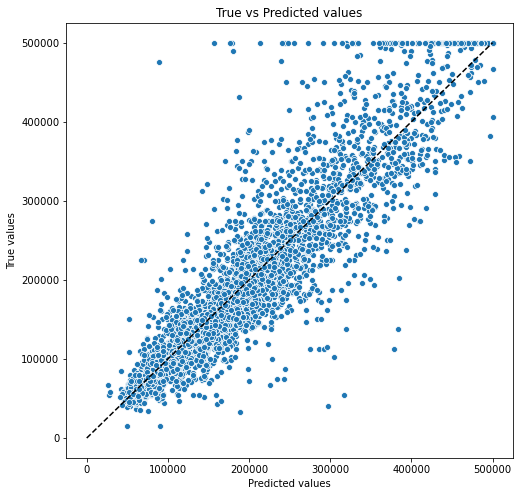

In [58]:
evaluate_preds(y_test['median_house_value'], y_pred_test)

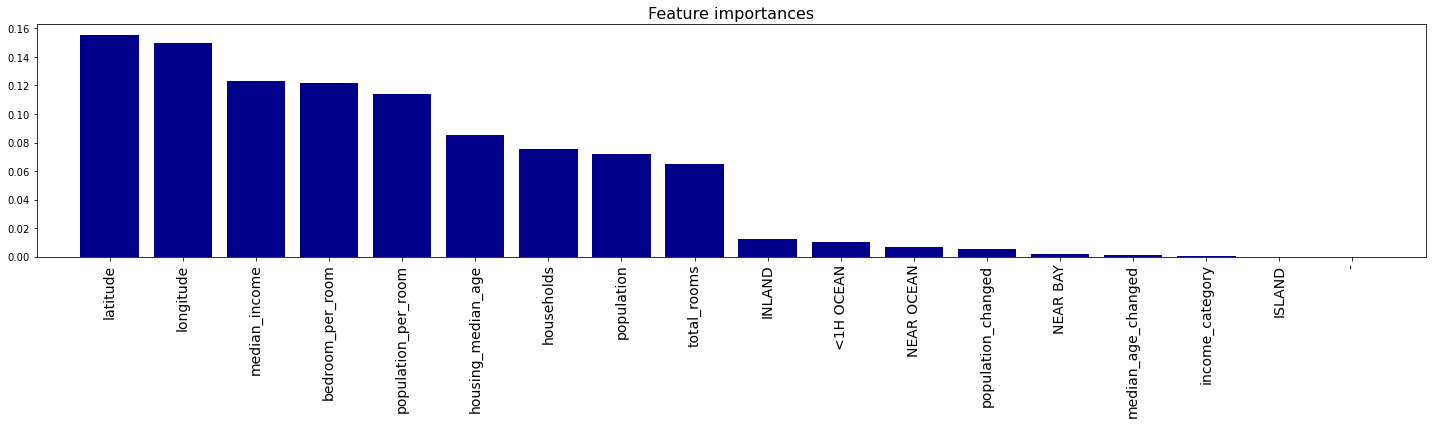

In [59]:
plot_feature_importances(importances = model.feature_importances_, X=X1)

## Учим финальную модель

In [60]:
model.fit(X1, y)

LGBMRegressor(max_depth=17, n_estimators=300, num_leaves=32, random_state=42)

In [61]:
y_pred = model.predict(X1_final)

for i in range(len(y_pred)):
    if y_pred[i] > 500000:
        y_pred[i] = 500001

In [62]:
y_pred_df = pd.DataFrame(y_pred, columns=['median_house_value'])

In [63]:
y_pred_df

,median_house_value
0,57497.249339
1,102452.107420
2,500001.000000
3,315475.408637
4,281443.094691
...,...
6807,177186.350956
6808,120634.685474
6809,121268.514508
6810,130800.321442


In [64]:
X_final.index

Int64Index([20046,  3024, 15663, 20484,  9814, 13311,  7113,  7668, 18246,
             5723,
            ...
             6557,  3383, 16201, 18186,  3592, 15316, 14772, 12870, 13476,
            16123],
           dtype='int64', name='Id ', length=6812)

In [65]:
filename = '201118_Reznik_1.csv'
y_pred_df.to_csv(filename, index=None)